## Poisson Regression Model
---


In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as st
from IPython.display import display

The following cell generate data from

\begin{align*}
 & \mathrm{P}(y_i=y|x_{1i},x_{2i}) = \frac{e^{-\lambda_i}\lambda_i^y}{y!},\quad y=0,1,2,\dots, \\
 & \lambda_i = \exp(0.5 x_{1i} - 0.5 x_{2i}),\quad i=1,\dots,500.
\end{align*}


In [2]:
n = 500
rng = np.random.default_rng(seed=99)
x1 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n, random_state=rng)
x2 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n, random_state=rng)
lam = np.exp(0.5*x1 - 0.5*x2)
y = st.poisson.rvs(lam, random_state=rng)
X = np.stack((np.ones(n), x1, x2), axis=1)

In [3]:
n, k = X.shape
b0 = np.zeros(k)
A0 = 0.01 * np.eye(k)
poisson_regression_model = pm.Model()
with poisson_regression_model:
    b = pm.MvNormal('b', mu=b0, tau=A0, shape=k)
    idx = pm.math.dot(X, b)
    likelihood = pm.Poisson('y', mu=pm.math.exp(idx), observed=y)

In [4]:
n_draws = 5000
n_chains = 4
n_tune = 1000
with poisson_regression_model:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, target_accept=0.9, random_seed=rng, nuts_sampler='numpyro', progressbar=False)
results = az.summary(trace, hdi_prob=0.95)
var_names = ['$\\beta_{:d}$'.format(index) for index in range(k)]
results.index = var_names
sim_param = dict([(var, trace.posterior['b'].values[:, :, index]) for index, var in enumerate(var_names)])

Compiling...
Compilation time = 0:00:02.116439
Sampling...
Sampling time = 0:00:01.970461
Transforming variables...
Transformation time = 0:00:00.066802


In [5]:
display(results)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
$\beta_0$,0.041,0.047,-0.056,0.130,0.0,0.0,13569.0,13516.0,1.0
$\beta_1$,0.481,0.043,0.395,0.563,0.0,0.0,13223.0,13771.0,1.0
$\beta_2$,-0.443,0.043,-0.527,-0.359,0.0,0.0,13652.0,13237.0,1.0


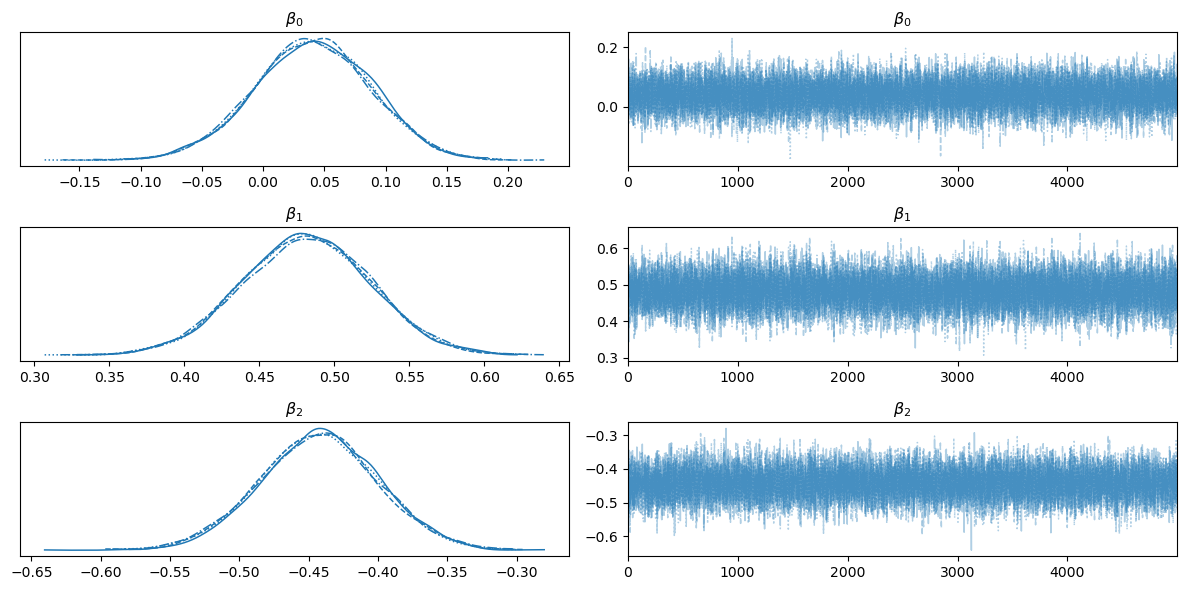

In [6]:
az.plot_trace(sim_param)
plt.tight_layout()
plt.show()

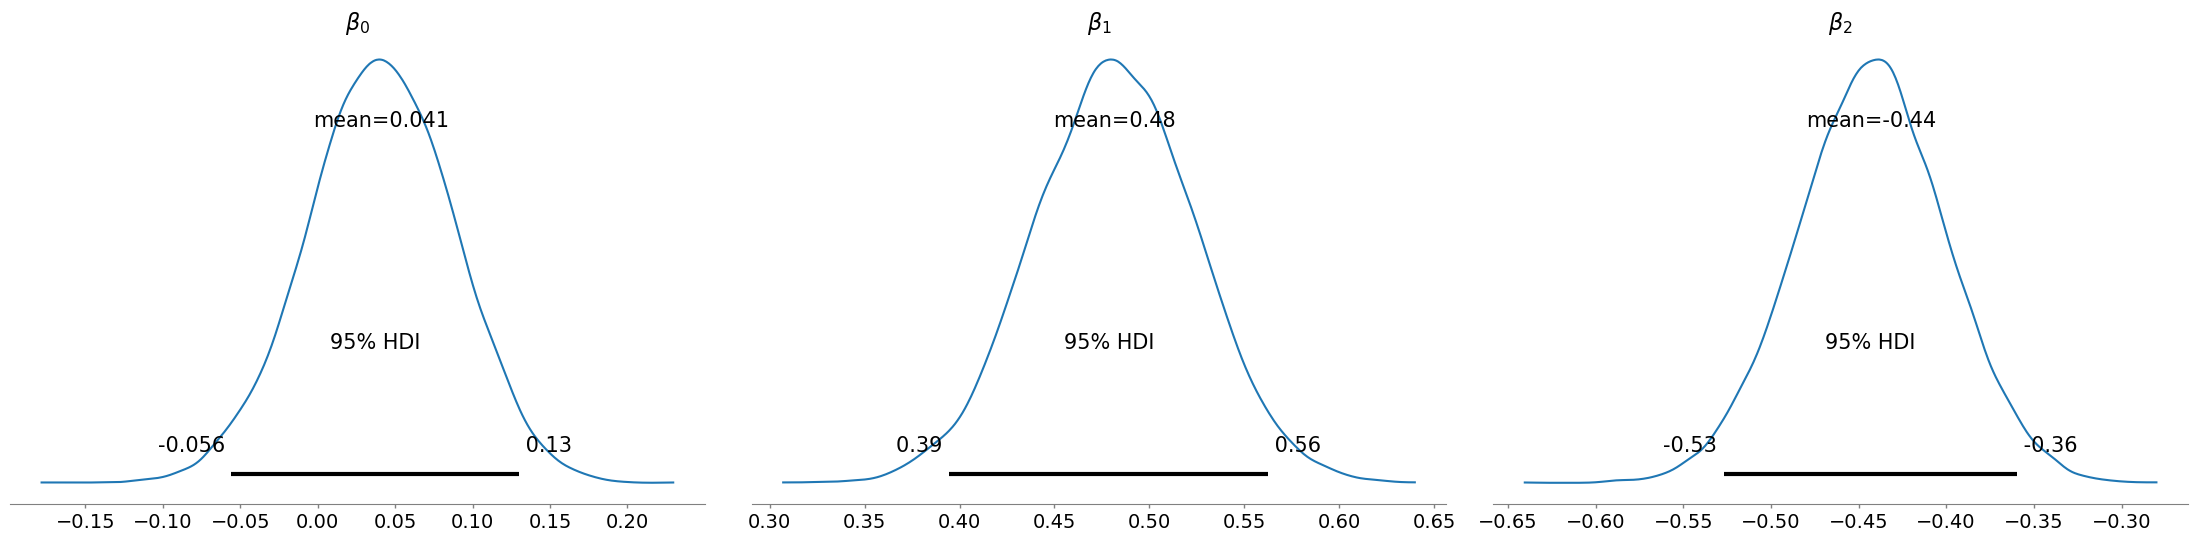

In [7]:
az.plot_posterior(sim_param, kind='kde', point_estimate='mean', hdi_prob=0.95)
plt.tight_layout()
plt.show()